In [1]:
import toml
import pandas as pd
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
from aging.plotting import format_plots, PlotConfig, save_factory, figure

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / 'size-normalization', tight_layout=False)

In [3]:
scan_path = Path('/n/groups/datta/win/longtogeny/size_norm/models/big_param_scan_00')

In [4]:
def get_mag(s):
    if s == 'K':
        return 1e3
    elif s == 'M':
        return 1e6
    elif s == 'B':
        return 1e9
    else:
        raise NotImplementedError()

## Parameter count vs reconstruction error

In [5]:
metrics = list(scan_path.glob("stage_01/**/metrics.csv"))

In [6]:
results = []
for f in tqdm(metrics):
    try:
        folder = f.parents[2]
        config = toml.load(folder / "config.toml")
        mse_df = pd.read_csv(f)
        tmp = mse_df.groupby('epoch').mean()
        with open(list(folder.glob('model*.out'))[0], 'r') as out_f:
            for line in out_f.readlines():
                if "Total params" in line:
                    params = line.split(' ')[:2]
                    params = float(params[0]) * get_mag(params[1])
        out = dict(
            depth=config['model']['depth'],
            arch=config['model']['lightning']['arch'],
            channel_scaling=config['model']['channel_scaling'],
            depth_scaling=config['model']['depth_scaling'],
            init_depth=config['model']['init_depth'],
            init_channel=config['model']['init_channel'],
            val_mse=None if 'val_loss' not in mse_df.columns else mse_df['val_loss'].min(),
            uuid=folder.name,
            train_mse=tmp['train_loss'].min(),
            epoch=mse_df['epoch'].max(),
            param_count=params,
            file=str(folder / "model.pt"),
            activation=config['model']['activation'],
        )
        if 'dynamics_correlation' in mse_df.columns:
            out['dynamics_corr'] = mse_df['dynamics_correlation'].dropna().iloc[-1]
        if 'age_classification' in mse_df.columns:
            out['age_class'] = mse_df['age_classification'].dropna().iloc[-1]
        results.append(out)
    except Exception:
        continue
results = pd.DataFrame(results)

  0%|          | 0/287 [00:00<?, ?it/s]

In [7]:
arch_rename = dict(ae='Autoencoder', unet='UNet', efficient='AE + EfficientNet conv', efficient_unet='UNet + EfficientNet conv')
results['arch'] = results['arch'].map(arch_rename)

In [8]:
results = (
    results.query("epoch == 100")
    .groupby(["init_channel", "arch", "channel_scaling", "epoch"])
    .mean(numeric_only=True)
    .reset_index()
)

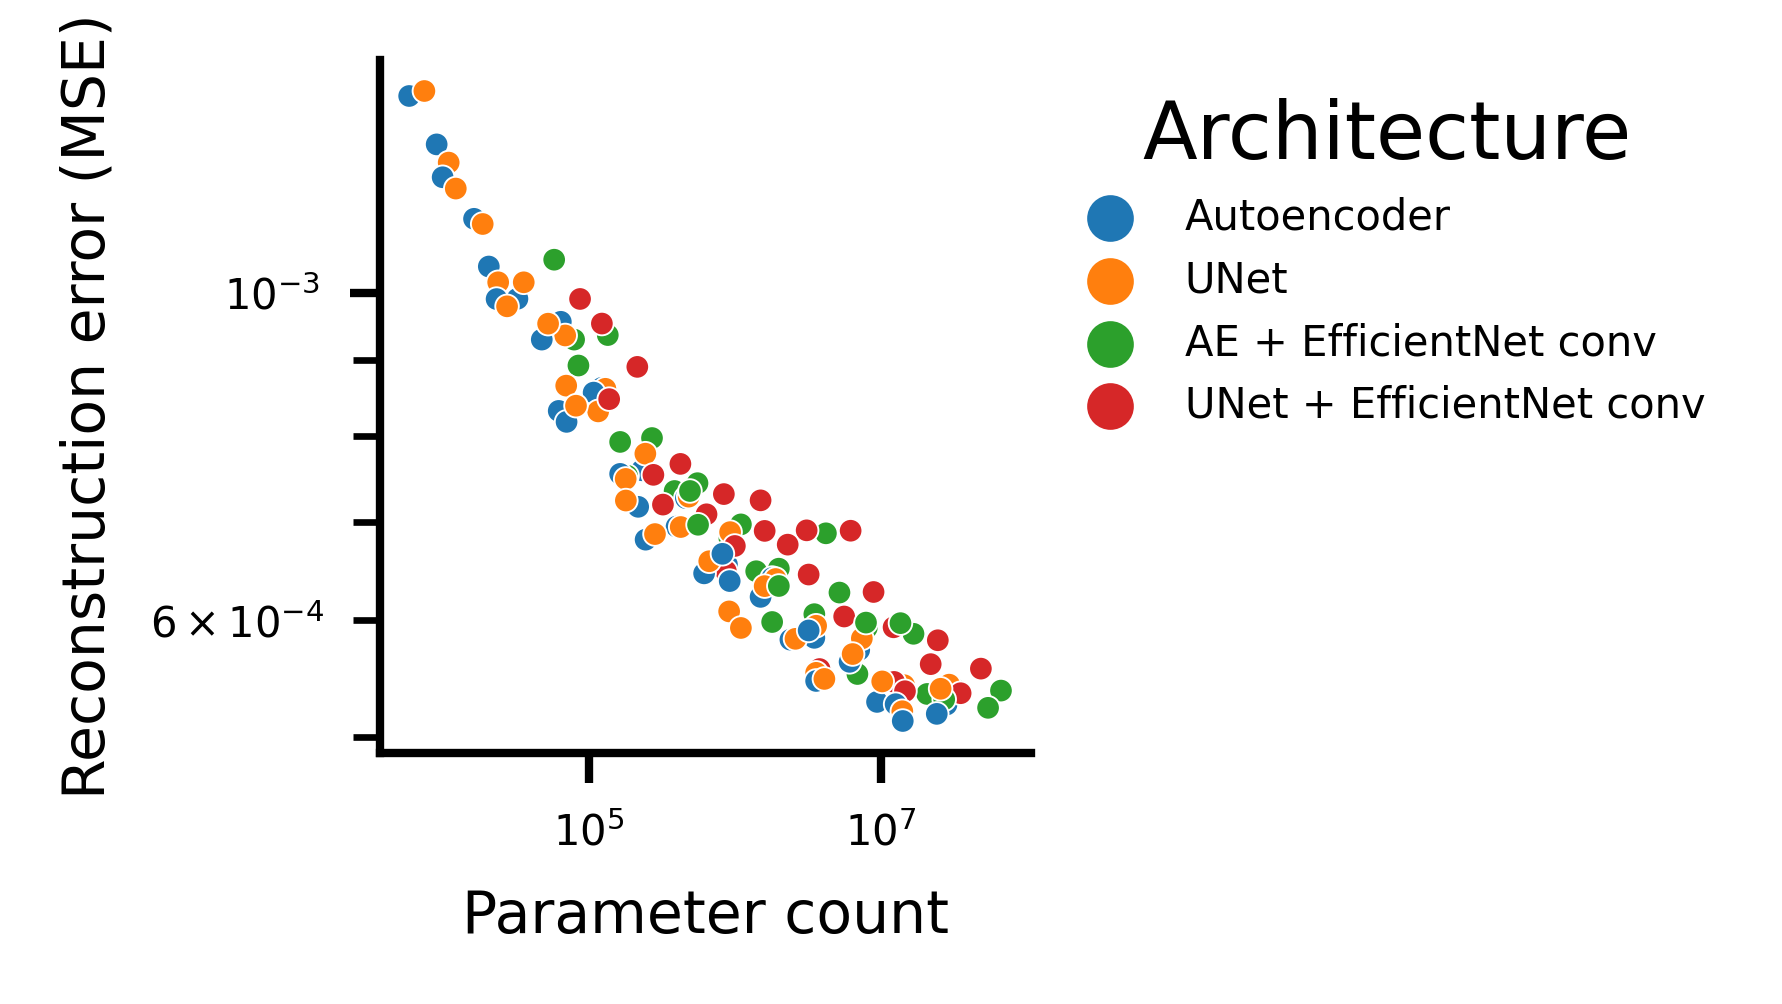

In [9]:
fig = figure(1.4, 1.5)
ax = sns.scatterplot(
    data=results,
    x="param_count",
    y="val_mse",
    hue="arch",
    s=8,
    hue_order=[
        "Autoencoder",
        "UNet",
        "AE + EfficientNet conv",
        "UNet + EfficientNet conv",
    ],
)
ax.set(
    xscale="log",
    yscale="log",
    xlabel="Parameter count",
    ylabel="Reconstruction error (MSE)",
)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False, title="Architecture")
sns.despine()
saver(fig, "parameter_counts_vs_mse");

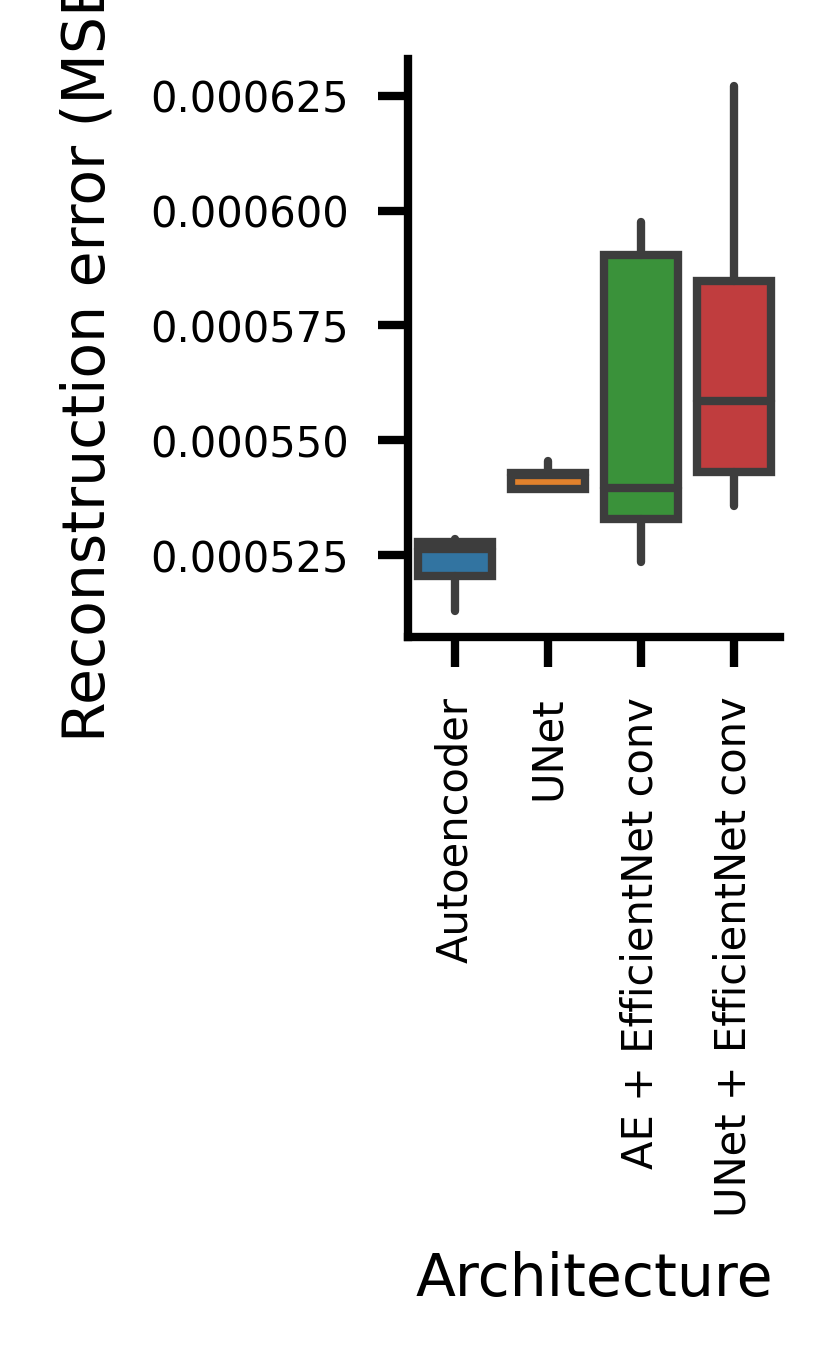

In [10]:
mask = results["param_count"].between(0.8e7, 6e7)
examples = results[mask]

fig = figure(0.8, 1.25)
ax = sns.boxplot(
    data=examples,
    x="arch",
    y="val_mse",
    order=["Autoencoder", "UNet", "AE + EfficientNet conv", "UNet + EfficientNet conv"],
    showfliers=False,
    showcaps=False,
)
ax.set(xlabel='Architecture', ylabel='Reconstruction error (MSE)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine()
saver(fig, 'arch-vs-mse');

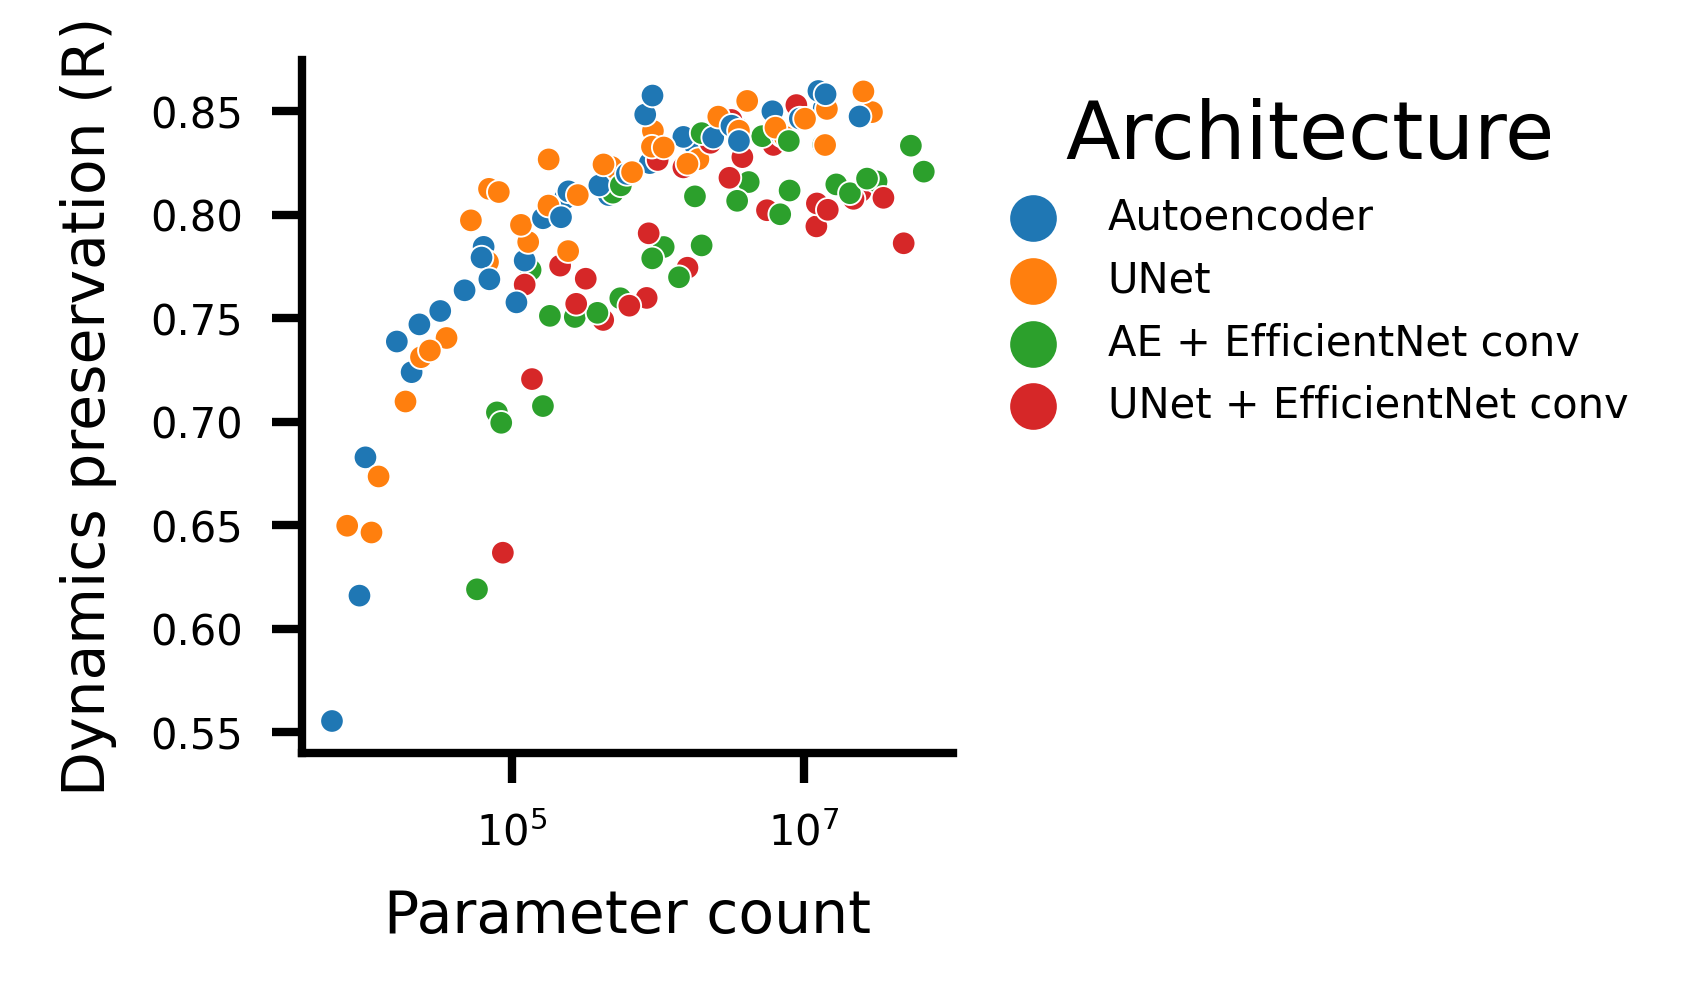

In [11]:
fig = figure(1.4, 1.5)
ax = sns.scatterplot(
    data=results,
    x="param_count",
    y="dynamics_corr",
    hue="arch",
    s=8,
    hue_order=[
        "Autoencoder",
        "UNet",
        "AE + EfficientNet conv",
        "UNet + EfficientNet conv",
    ],
)
ax.set(
    xscale="log",
    xlabel="Parameter count",
    ylabel="Dynamics preservation (R)",
)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False, title="Architecture")
sns.despine()
saver(fig, "parameter_counts_vs_beh_pres");